In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam, RMSprop
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
import h5py
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import itertools
#for broken data stream error
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_path = '/home/furkan/Documents/Fire-vs-NoFire/Training'
test_path = '/home/furkan/Documents/Fire-vs-NoFire/Test'

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input, validation_split=0.2)
train_batches = train_datagen.flow_from_directory(train_path, batch_size=16, subset='training')

valid_batches = train_datagen.flow_from_directory(train_path, batch_size=16, subset='validation')

test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path, batch_size=16, shuffle=False)

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


# Modify Model

In [4]:
mobile = keras.applications.mobilenet.MobileNet()

In [5]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [6]:
#Deleting the last 5 layers and replacing it with a dense softmax layer consisting of 2 nodes: Fire and Non-fire
x = mobile.layers[-6].output
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=mobile.input, outputs=predictions)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [8]:
#Freezing weights all the layers upto the 4th last layer
#This is done because we will retrain only the last three layers
for layer in model.layers[:-4]:
    layer.trainable = False

# Train the model

In [13]:
model.compile(RMSprop(lr=.00001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [14]:
checkpointer = ModelCheckpoint(filepath = '/home/furkan/Documents/my_model_inferno.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.000001)

In [17]:
history = model.fit_generator(train_batches, 
                    validation_data=valid_batches, epochs=10, shuffle=True, verbose=1, callbacks=[checkpointer,reduce_lr])

Epoch 1/10
1969/1969 [==============================] - 842s 428ms/step - loss: 0.2622 - categorical_accuracy: 0.9485 - val_loss: 0.0915 - val_categorical_accuracy: 0.9580

Epoch 00001: val_loss improved from inf to 0.09151, saving model to /home/furkan/Documents/my_model_inferno.h5
Epoch 2/10
1969/1969 [==============================] - 795s 404ms/step - loss: 0.1342 - categorical_accuracy: 0.9585 - val_loss: 0.0730 - val_categorical_accuracy: 0.9591

Epoch 00002: val_loss improved from 0.09151 to 0.07296, saving model to /home/furkan/Documents/my_model_inferno.h5
Epoch 3/10
1969/1969 [==============================] - 796s 404ms/step - loss: 0.1167 - categorical_accuracy: 0.9624 - val_loss: 0.0662 - val_categorical_accuracy: 0.9602

Epoch 00003: val_loss improved from 0.07296 to 0.06621, saving model to /home/furkan/Documents/my_model_inferno.h5
Epoch 4/10
1969/1969 [==============================] - 797s 405ms/step - loss: 0.1007 - categorical_accuracy: 0.9670 - val_loss: 0.0638 - v

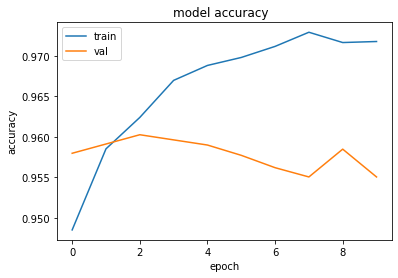

In [19]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'] )
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy  ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

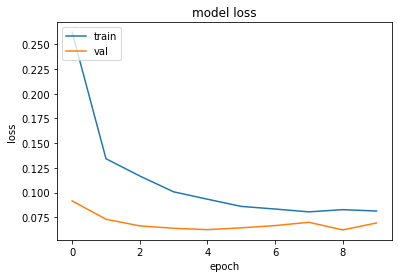

In [20]:
# summarize history for loss
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Test the model and plot confusion matrix

In [21]:
test_labels = test_batches.classes

In [22]:
len(test_batches)

539

In [23]:
test_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [24]:
test_batches.class_indices

{'Fire': 0, 'No_Fire': 1}

In [25]:
predictions = model.predict_generator(test_batches, verbose=1)

/home/furkan/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


539/539 [==============================] - 186s 344ms/step


In [27]:
test_steps = (test_batches.n // test_batches.batch_size)+1

In [29]:
model.evaluate_generator(test_batches, verbose=1, steps=test_steps)

/home/furkan/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


539/539 [==============================] - 172s 320ms/step - loss: 0.7993 - categorical_accuracy: 0.6638


[0.7992879748344421, 0.6638041138648987]

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [31]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [32]:
test_batches.class_indices

{'Fire': 0, 'No_Fire': 1}

Confusion matrix, without normalization
[[4661  476]
 [2421 1059]]


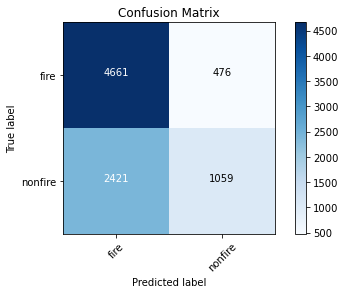

In [33]:
cm_plot_labels = ['fire','nonfire']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')